# Theano

#### TL; DR
Theano is used as a mathematical numerical optimizer for Python. As an optimizer Theano takes code and tries to squeeze as much performance possible by using symoblic syntax. It is designed to handle the heavy computations for Neural Nets.

### HMM & Theano
Because we don't always know the shape of the input matrix we can make use of Theano's symbolic library.

Theano's scan function can be used as an alternative to a "for" loop as it generally faster than Python's for loop by minimizing the number of GPU transfers and can lower overall memory usage by detecting amount of memory needed


In [1]:
import numpy as np
import theano
import theano.tensor as T

In [2]:
x = T.vector('x')

In [3]:
def square(x):
    return x*x

In [4]:
outputs, updates = theano.scan(
    fn=square,
    sequences=x,
    n_steps=x.shape[0]
)

In [5]:
square_op = theano.function(
    inputs=[x],
    outputs=[outputs]
)

In [7]:
o_val = square_op(np.array([x for x in range(6)]))

In [8]:
print("output:", o_val)

output: [array([ 0.,  1.,  4.,  9., 16., 25.])]


In [9]:
N = T.iscalar('N')

In [10]:
def recurrence(n, fn_1, fn_2):
    return fn_1 + fn_2, fn_1

In [11]:
outputs, updates = theano.scan(
    fn=recurrence,
    sequences=T.arange(N),
    n_steps=N,
    outputs_info=[1.,1.]
)

In [12]:
fibonacci = theano.function(
    inputs=[N],
    outputs=outputs
)

In [13]:
o_val = fibonacci(8)

In [14]:
print("output:", o_val)

output: [array([ 2.,  3.,  5.,  8., 13., 21., 34., 55.], dtype=float32), array([ 1.,  2.,  3.,  5.,  8., 13., 21., 34.], dtype=float32)]


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
X = 2*np.random.randn(300) + np.sin(np.linspace(0, 3*np.pi, 300))

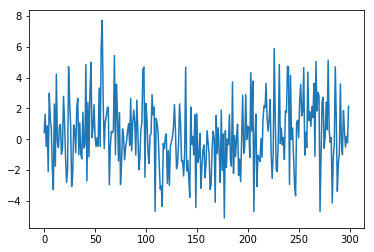

In [18]:
plt.plot(X)
plt.show()

In [19]:
decay = T.scalar('decay')
sequence = T.vector('sequence')

In [20]:
def recurrence(x, last, decay):
    return (1-decay)*x + decay*last

In [21]:
outputs, _ = theano.scan(
    fn=recurrence,
    sequences=sequence,
    n_steps=sequence.shape[0],
    outputs_info=[np.float64(0)],
    non_sequences=[decay],
)

In [22]:
lpf = theano.function(
    inputs=[sequence, decay],
    outputs=outputs
)

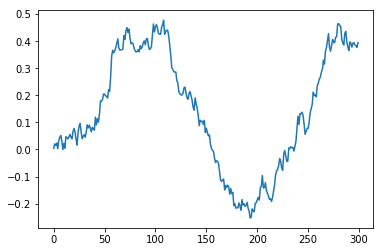

In [24]:
Y = lpf(X, 0.99)
plt.plot(Y)
plt.show()

### HMM w/ Gradient Descent

Softmax (revisited) for probabilities

$$softmax(x)_{i}=\frac{exp(x_{i})}{\sum_{k=1}^K exp(x_{k})}$$

W.R.T to HMM you can use $softmax(\theta)=\pi$ 

In [25]:
def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1, keepdims=True)

In [26]:
A = np.random.randn(5,3)
print(softmax(A))

[[0.4030936  0.51736216 0.07954424]
 [0.11070819 0.64564638 0.24364544]
 [0.12751182 0.22075504 0.65173314]
 [0.70026981 0.2252156  0.07451459]
 [0.46847276 0.15042713 0.38110012]]


# Tensorflow

You create variables and link them functionally

#### Scan
Just like Theano scan let's us dynamically adjust the length of modeling sequence

Anatomy of the scan function

`outputs=tf.scan(fn=some_function, elems=thing_to_loop_over)`

`def some_function(last_output, element):`
    `return current*current`
    
Need to run it in a session

In [27]:
import tensorflow as tf

/Users/marktblack/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Users/marktblack/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


In [28]:
x = tf.placeholder(tf.int32, shape=(None,), name='x') #1D array (shape) = scalar

def square(last, current):
    return current*current

In [29]:
square_op = tf.scan(fn=square, elems=x)

Instructions for updating:
Colocations handled automatically by placer.


In [30]:
with tf.Session() as session:
    o_val = session.run(square_op, feed_dict={x:[1,2,3,4,5]})
    print("output:", o_val)

output: [ 1  4  9 16 25]


### Initializer

Allows us to compute recurrence functions

Strict Rules

- initializer must have the exact same type as recurrence output
- if recurrence returns multiple things, it will be stored as tuple (cannot use list)

**Fibonacci**
$$Fib(n)=Fib(n-1)+Fib(n-2)$$

In [31]:
N = tf.placeholder(tf.int32, shape=(), name='N') #shape=() -> tuple scalar

In [33]:
def recurrence(last_output, current_input):
    return (last_output[1], last_output[0] + last_output[1])

In [34]:
fibonacci = tf.scan(
    fn=recurrence,
    elems=tf.range(N),
    initializer=(0,1),
)

In [35]:
with tf.Session() as session:
    o_val = session.run(fibonacci, feed_dict={N:8})
    print("output:", o_val)

output: (array([ 1,  1,  2,  3,  5,  8, 13, 21], dtype=int32), array([ 1,  2,  3,  5,  8, 13, 21, 34], dtype=int32))


### Low Pass Filter (aka Moving Average Filter)

recurrence relation is given by

`s(t)=decay_rate*s(t-1)+(1-decay_rate)*x(t)`
where `x(t)=input, s(t)=output`

In [39]:
orig = np.sin(np.linspace(0, 3*np.pi, 300))
X = 2*np.random.randn(300) + orig

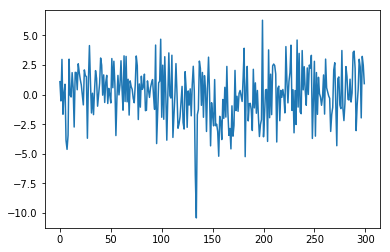

In [41]:
plt.plot(X)
plt.show()

In [42]:
decay = tf.placeholder(tf.float32, shape=(), name='decay')
sequence = tf.placeholder(tf.float32, shape=(None,), name='sequence')

In [43]:
def recurrence(last, x):
    return (1.0-decay)*x + decay*last

In [44]:
lpf = tf.scan(
    fn=recurrence,
    elems=sequence,
    initializer=0.0
)

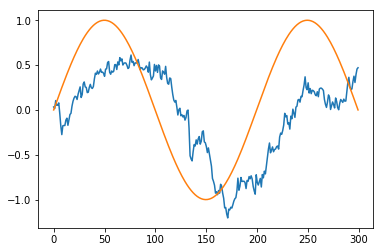

In [47]:
with tf.Session() as session:
    Y = session.run(lpf, feed_dict={sequence: X, decay: 0.97})
    plt.plot(Y)
    plt.plot(orig)
    plt.show()

## Discrete HMM w/ Tensorflow

Code: https://github.com/lazyprogrammer/machine_learning_examples/blob/master/hmm_class/hmmd_tf.py